In [1]:
!pip -q install geopandas shapely rasterio pyproj tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 81.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive/CASA0004_Cycling/data'

Mounted at /content/drive
BoroughShp
city_of_london_bike_accessible_roads.geojson
COL_cycleavailable.geojson
COL_cyclelane.geojson
Env
greater_london_bike_accessible_roads.geojson
GreatLondonShp
Results
Roads
Slope


In [3]:
import math
import numpy as np
import rasterio
from shapely.geometry import LineString, MultiLineString
from tqdm import tqdm

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely.strtree import STRtree
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# —— 可调参数 ——
SLOPE_TIF = "/content/drive/MyDrive/CASA0004_Cycling/data/Slope/slope_test/slope.tif"
INTERVAL_M = 10.0             # 采样间距（米）
STAT_KIND  = "q3"             # "q3" | "mean" | "max"
SLOPE_UNIT = "degree"         # 栅格单位："degree" or "percent"
CHUNK_SIZE = 20000            # 分块行数，视内存调整
OUTPUT     = "/content/drive/MyDrive/CASA0004_Cycling/data/Roads/AAA_export_with_slope.geojson"

In [5]:
road_gdf = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/Roads/AAA.geojson")
print(road_gdf.columns)

Index(['id', 'name', 'way_type', 'index', 'index_10', 'stress_level', 'offset',
       'side', 'proc_width', 'proc_surface', 'proc_smoothness', 'proc_oneway',
       'proc_sidepath', 'proc_highway', 'proc_maxspeed',
       'proc_traffic_mode_left', 'proc_traffic_mode_right',
       'proc_separation_left', 'proc_separation_right', 'proc_buffer_left',
       'proc_buffer_right', 'proc_mandatory', 'proc_traffic_sign', 'fac_width',
       'fac_surface', 'fac_highway', 'fac_maxspeed', 'base_index', 'fac_1',
       'fac_2', 'fac_3', 'fac_4', 'data_bonus', 'data_malus',
       'data_incompleteness', 'data_missing', 'data_missing_width',
       'data_missing_surface', 'data_missing_smoothness',
       'data_missing_maxspeed', 'data_missing_parking', 'data_missing_lit',
       'filter_usable', 'filter_way_type', 'layer', 'path', 'geometry'],
      dtype='object')


In [6]:
def line_points_every(line: LineString, step: float):
    """沿 LineString 每 step 米取点（含终点）。"""
    if not line or line.length == 0:
        return []
    n = max(1, int(math.floor(line.length / step)))
    dists = [i * step for i in range(n)] + [line.length]
    return [line.interpolate(d).coords[0] for d in dists]

def geom_points(geom, step: float):
    if geom is None:
        return []
    if isinstance(geom, LineString):
        return line_points_every(geom, step)
    if isinstance(geom, MultiLineString):
        pts = []
        for part in geom.geoms:
            pts.extend(line_points_every(part, step))
        return pts
    return []

def calc_stat(vals, kind="q3"):
    if not vals:
        return 0.0
    arr = np.asarray(vals, dtype=float)
    if kind == "mean": return float(np.nanmean(arr))
    if kind == "max":  return float(np.nanmax(arr))
    return float(np.nanpercentile(arr, 75))  # q3

def slope_to_percent(v, unit="degree"):
    if unit == "percent": return float(v)
    return float(math.tan(math.radians(v)) * 100.0)

def slope_to_factor(slope_pct: float) -> float:
    # 你之前的规则
    if slope_pct <= 2:   return 1.0
    if slope_pct <= 4:   return 0.9
    if slope_pct <= 6:   return 0.75
    if slope_pct <= 8:   return 0.6
    if slope_pct <= 10:  return 0.45
    return 0.3

In [7]:
# 打开坡度栅格
ds = rasterio.open(SLOPE_TIF)
raster_crs = ds.crs
nodata = ds.nodata

# 确保道路与栅格同一 CRS
if road_gdf.crs is None:
    raise RuntimeError("road_gdf 没有 CRS，请先设定。")
if raster_crs and road_gdf.crs.to_wkt() != raster_crs.to_wkt():
    road_gdf = road_gdf.to_crs(raster_crs)

# 建字段
if "proc_slope" not in road_gdf.columns:
    road_gdf["proc_slope"] = np.nan
if "fac_3" not in road_gdf.columns:
    road_gdf["fac_3"] = np.nan


In [8]:
total = len(road_gdf)
pbar = tqdm(total=total, desc="Sampling slope", unit="feat")

start = 0
while start < total:
    end = min(start + CHUNK_SIZE, total)
    sub = road_gdf.iloc[start:end].copy()

    proc_vals = np.zeros(len(sub))
    fac_vals  = np.ones(len(sub))

    # 为每条线生成采样点 → 栅格采样 → 统计
    for i, geom in enumerate(sub.geometry.values):
        pts = geom_points(geom, INTERVAL_M)
        if not pts:
            proc_vals[i] = 0.0
            fac_vals[i]  = 1.0
            continue

        # rasterio.sample 需要 [(x,y), ...]
        smps = list(ds.sample(pts))
        vals = []
        for s in smps:
            if s is None or len(s) == 0:
                continue
            v = s[0]
            if v is None:
                continue
            if (nodata is not None and v == nodata) or np.isnan(v):
                continue
            vals.append(float(v))

        stat_v = calc_stat(vals, STAT_KIND)
        slope_pct = slope_to_percent(stat_v, SLOPE_UNIT)
        factor = slope_to_factor(slope_pct)

        proc_vals[i] = round(slope_pct, 2)
        fac_vals[i]  = round(factor, 2)

    # 写回
    road_gdf.loc[sub.index, "proc_slope"] = proc_vals
    road_gdf.loc[sub.index, "fac_3"] = fac_vals

    pbar.update(len(sub))
    start = end

pbar.close()


Sampling slope: 100%|██████████| 278172/278172 [05:44<00:00, 808.59feat/s]


In [9]:
ext = OUTPUT.lower().split(".")[-1]
if ext == "gpkg":
    road_gdf.to_file(OUTPUT, driver="GPKG")
else:
    road_gdf.to_file(OUTPUT, driver="GeoJSON")
print("Saved to:", OUTPUT)


Saved to: /content/drive/MyDrive/CASA0004_Cycling/data/Roads/AAA_export_with_slope.geojson


In [10]:
print(road_gdf.columns)

Index(['id', 'name', 'way_type', 'index', 'index_10', 'stress_level', 'offset',
       'side', 'proc_width', 'proc_surface', 'proc_smoothness', 'proc_oneway',
       'proc_sidepath', 'proc_highway', 'proc_maxspeed',
       'proc_traffic_mode_left', 'proc_traffic_mode_right',
       'proc_separation_left', 'proc_separation_right', 'proc_buffer_left',
       'proc_buffer_right', 'proc_mandatory', 'proc_traffic_sign', 'fac_width',
       'fac_surface', 'fac_highway', 'fac_maxspeed', 'base_index', 'fac_1',
       'fac_2', 'fac_3', 'fac_4', 'data_bonus', 'data_malus',
       'data_incompleteness', 'data_missing', 'data_missing_width',
       'data_missing_surface', 'data_missing_smoothness',
       'data_missing_maxspeed', 'data_missing_parking', 'data_missing_lit',
       'filter_usable', 'filter_way_type', 'layer', 'path', 'geometry',
       'proc_slope'],
      dtype='object')


In [11]:
print("CRS:", ds.crs)
print("Width (cols):", ds.width)
print("Height (rows):", ds.height)
print("Transform:", ds.transform)
print("Pixel size (res):", ds.res)


CRS: EPSG:27700
Width (cols): 11676
Height (rows): 9016
Transform: | 5.00, 0.00, 503573.42|
| 0.00,-5.00, 200936.64|
| 0.00, 0.00, 1.00|
Pixel size (res): (5.000138720452213, 5.000138720452213)


count    278172.000000
mean          0.868152
std           0.194812
min           0.300000
25%           0.750000
50%           0.900000
75%           1.000000
max           1.000000
Name: fac_3, dtype: float64


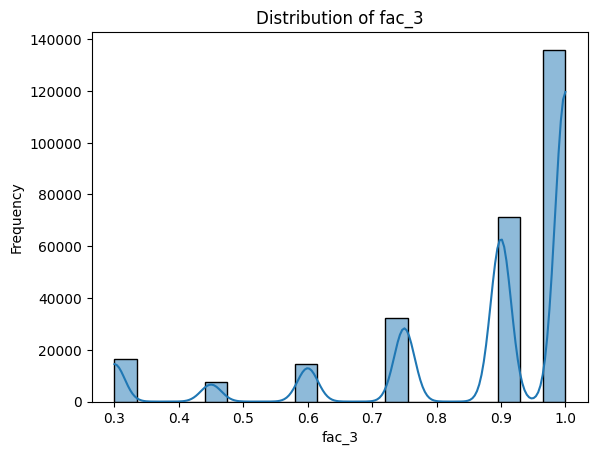

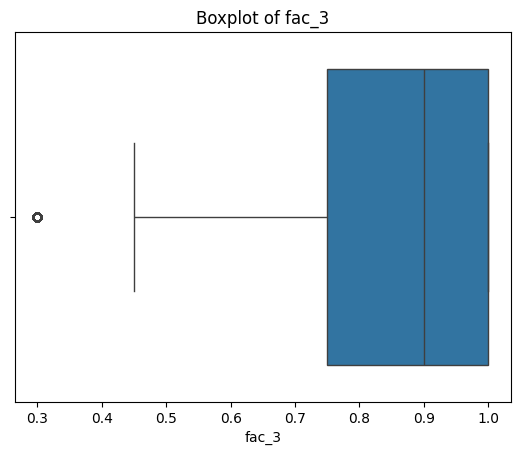

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 基本统计信息
print(road_gdf['fac_3'].describe())

# 2. 直方图 + 核密度曲线
sns.histplot(road_gdf['fac_3'], kde=True, bins=20)
plt.title('Distribution of fac_3')
plt.xlabel('fac_3')
plt.ylabel('Frequency')
plt.show()

# 3. 箱线图（看中位数和异常值）
sns.boxplot(x=road_gdf['fac_3'])
plt.title('Boxplot of fac_3')
plt.show()


count    278172.000000
mean          4.186173
std          24.589751
min           0.000000
25%           0.950000
50%           2.060000
75%           4.050000
max        2373.450000
Name: proc_slope, dtype: float64


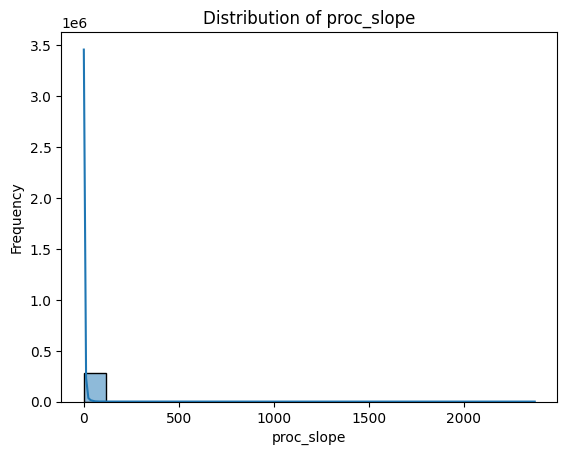

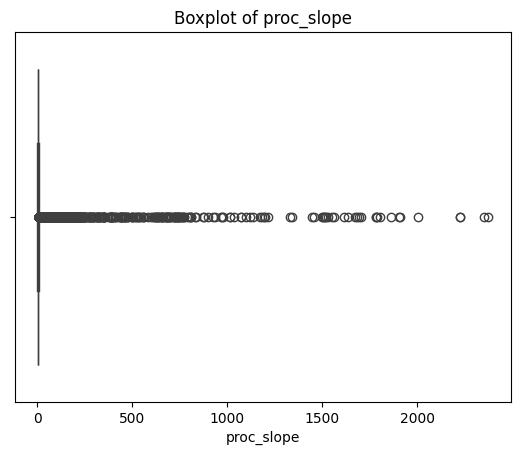

In [13]:
# 1. 基本统计信息
print(road_gdf['proc_slope'].describe())

# 2. 直方图 + 核密度曲线
sns.histplot(road_gdf['proc_slope'], kde=True, bins=20)
plt.title('Distribution of proc_slope')
plt.xlabel('proc_slope')
plt.ylabel('Frequency')
plt.show()

# 3. 箱线图（看中位数和异常值）
sns.boxplot(x=road_gdf['proc_slope'])
plt.title('Boxplot of proc_slope')
plt.show()
